In [177]:
sys.path.append('../TheoryOfMindInferenceModels-master/')
from SetupTransitionTable import SetupDeterministicTransitionByGrid
import itertools
from SetupRewardTable import SetupRewardTableWithDistanceMoveCost
from visualizations import *

sys.path.append('../TheoryOfMindInferenceModels-master/Demo3-InversePlanning')
from GoalInferenceVisualizations import *
from GoalInferenceSolution import PerformGoalInference

from pprint import pprint
import math
import matplotlib.pyplot as plt

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

### Environmentalism:

In [178]:
goalStates = [(1,1), (2,0)]
goalNames = {(1,1):'A', (2,0):'B'}
gridWidth = 3
gridHeight = 3
allActions = [(1,0), (0,1), (-1,0), (0,-1),(-1,1), (1,-1), (1,1), (-1,-1)]
trapStates = [(1,0)]

### Calculatory variables:

In [179]:
convergenceThreshold = 10e-1
gamma = 0.95
beta = .4

Now we call the Boltzmann class. Here is what happens on the inside:
As a reminder,
* `transition`:           {state:{action:nextState:probability}}  mind you, probability is always 1 (deterministic transitions)
* `reward`:               {state:{action:{next_state:value}}}
* `value`:                {state:0} for all cells
* `convergenceThreshold`: 10e-7
* `gamma`:                .95
* `beta`:                 .4

In [180]:
normalize_dict = lambda dictionary : {key: val/sum(dictionary.values()) for key, val in dictionary.items()}

class BoltzmannValueIteration(object):
    def __init__(self, transitionTable, rewardTable, valueTable, convergenceTolerance, discountingFactor, beta):
        self.transitionTable = transitionTable
        self.rewardTable  = rewardTable
        self.valueTable = valueTable
        self.convergenceTolerance = convergenceTolerance
        self.gamma = discountingFactor
        self.beta = beta
    
    def __call__(self):
        delta = self.convergenceTolerance*100

        while(delta > self.convergenceTolerance):

            delta = 0
            for state, actionDict in self.transitionTable.items():
                valueOfStateAtTimeT = self.valueTable[state]
                qforAllActions = [self.getQValue(state, action) for action in actionDict.keys()]
                self.valueTable[state] = max(qforAllActions) 
                delta = max(delta, abs(valueOfStateAtTimeT-self.valueTable[state]))

            #raise StopExecution
        policyTable = {state:self.getBoltzmannPolicy(state) for state in self.transitionTable.keys()}
        return [self.valueTable, policyTable]
    
    def getQValue(self, state, action):
        # prob always 1 in deterministic transitions
        # reward: {state:{action:{next_state:value}}}, fixed,value = state - move_cost (state = 10 for goal, 0 for others, -100 for obstacles)
        # value : {state:value}, 0 at the beginning
        nextStatesQ = [prob*(self.rewardTable[state][action][nextState] \
                                + self.gamma*self.valueTable[nextState]) \
                        for nextState, prob in self.transitionTable[state][action].items()]
        qValue = sum(nextStatesQ)
        return qValue

    def getBoltzmannPolicy(self, state, printStatments=False):
        actions = list(self.transitionTable[state].keys())
        exponents = [self.beta*self.getQValue(state, action) for action in actions]    

        # Scale to [0,700] if there are exponents larger than 700
        if any([exponent > 700 for exponent in exponents]):
            if printStatments:
                print("scaling exponents to [0,700]... On State:", "\n", state)
            exponents = [700*(exponent/max(exponents)) for exponent in exponents]

        statePolicy = {action: math.exp(exponent) for exponent, action in zip(exponents,actions)}
        return normalize_dict(statePolicy)

What happens in `__call__`?

<pre><code>while (> convergence threshold):
    delta <- 0
    for all states and set of actions in that state:
        value(s_t) <- valueTable[state] #0 at the beginning
        for all actions in action set:
            qValue <- QValue(state, action)
        valueTable[state] <- max(qValues of all actions)
        delta <- max(delta, abs(value(s_t) - valueTable[state]))
policyTable <- {state:BoltzmannPolicy(state)} for all states
return valueTable, policyTable
</code></pre>

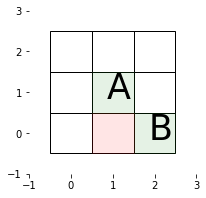

In [181]:
getTransition = SetupDeterministicTransitionByGrid(gridWidth, gridHeight, allActions)
transition = getTransition()
stateSet = list(itertools.product(range(gridWidth), range(gridHeight)))
visualizeEnvironmentByState(states= stateSet, 
                            goalStates = goalStates, 
                            trapStates = trapStates, 
                            goalNameDictionary=goalNames)

Now we get started with the setup of the policies. First, get all possible transitions, and all possible states.

`transition` is a nested dictionary {state:{action:nextState:probability}} where there is every state and action pair and only the next states that result in a non-zero probability

`stateSet` is just all possible states (so all cells)

now we set up the reward table. For this, we need the goal state (A).

`reward` has the form { state : { action : { next_state : value }}}. The value depends on state - move_cost, not on next_state.

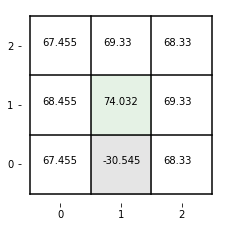

In [182]:
goalStateA = (1,1)

getRewardA = SetupRewardTableWithDistanceMoveCost(transition, allActions, [goalStateA], trapStates)
rewardA = getRewardA()
valueA = {state:0 for state in rewardA.keys()}

performValueIterationA = BoltzmannValueIteration(transition, rewardA, valueA, convergenceThreshold, gamma, beta)
optimalValuesA, policyA = performValueIterationA()

visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, 
                    goalState = goalStateA, trapStates = trapStates, valueTable = optimalValuesA)


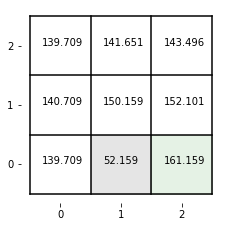

In [183]:
goalStateB = (2,0)

getRewardB = SetupRewardTableWithDistanceMoveCost(transition, allActions, [goalStateB], trapStates)
rewardB = getRewardB()
valueB = {state:0 for state in rewardB.keys()}

performValueIterationB = BoltzmannValueIteration(transition, rewardB, valueB, convergenceThreshold, gamma, beta)
optimalValuesB, policyB = performValueIterationB()

visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, 
                    goalState = goalStateB, trapStates = trapStates, valueTable = optimalValuesB)

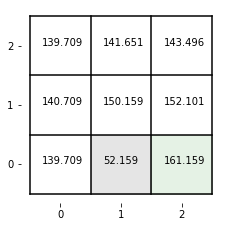

TypeError: visualizePolicy() got an unexpected keyword argument 'otherGoals'

In [184]:
optimalValues = optimalValuesB #optimalValuesB, optimalValuesC
currentGoal = goalStateB #goalStateB goalStateC
piPolicy = policyB #policyB, policyC

visualizeValueTable(gridWidth = gridWidth, gridHeight = gridHeight, goalState = currentGoal, trapStates = trapStates, valueTable = optimalValues)

visualizePolicy(stateSet, piPolicy, currentGoal, otherGoals=goalStates, trapStates=trapStates)

# Here goes nothing: The Inference

The goal inference class takes in a transition function describing the dynamics of the environment, a set of  policies corresponding to the possible goals in the environment, a prior over how likely each goal is at time 0, and an actual observed trajectory of actions observed in the environment.

It outputs a posterior distribution over the goals at each time point in the trajectory

## Setup and Helper Functions

In [133]:
def plotPosteriors(posteriors, title="", labels=['A', 'B']):
    
    x = range(len(posteriors[:, 0]))
    plt.title(title)
    plt.plot(x, posteriors[:,0])
    plt.plot(x, posteriors[:,1])

    plt.legend(labels)
    plt.show()

## Fixed Trajectories?

In [134]:
environment1Policies = [policyA, policyB]
environment1Priors = [1/2, 1/2]

In [139]:
#Observed Trajectories
trajectoryToGoalA = [(0,0), (0,1), (0,2), (1,1)]
trajectoryToGoalB = [(0,0), (0,1), (1,1), (2,0)]

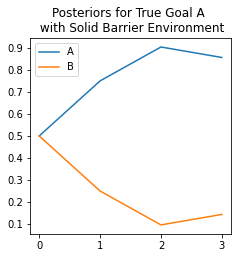

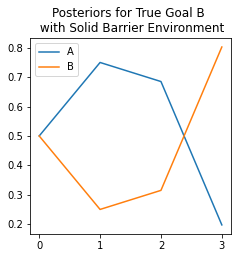

In [140]:
inferGoalA = PerformGoalInference(transition, environment1Policies, environment1Priors, trajectoryToGoalA)
posteriorsToGoalA = inferGoalA()
plotPosteriors(posteriorsToGoalA, "Posteriors for True Goal A \n with Solid Barrier Environment")

inferGoalB = PerformGoalInference(transition, environment1Policies, environment1Priors, trajectoryToGoalB)
posteriorsToGoalB = inferGoalB()
plotPosteriors(posteriorsToGoalB,"Posteriors for True Goal B \n with Solid Barrier Environment")

## Example Trajectory Sampling
Before we used fixed trajectories, instead, we can sample a goal and a corresponding trajectory to solve the same inference problem

In [185]:
def samplePathToGoal(position, policy, transition, goals):
    trajectory = [position]
    while position not in goals:
        #take action probabilisitically
        actions = list(policy[position].keys())
        probOfAction = [policy[position][action] for action in actions]
        actionIndex = np.random.choice(len(actions), size = 1, p = probOfAction)
        sampledAction = actions[int(actionIndex)]
        
        #get new position
        newPosition = list(transition[position][sampledAction].keys())[0]
        
        #update to new position and add to trajectory
        position = newPosition
        trajectory.append(position)
    return trajectory

Here we can sample a goal and a trajectory for that goal under the specified environment.

Visualization for example sampled trajectories follows

In [186]:
#USER SPECIFIED PREFERENCES:

#Change to reflect true goal/environment of choice
startingPosition = (0,0) #any state in the world

#Choose Enviornment
env = 'barrier' # choose 'barrier' for environment 1, gap' otherwise

(2, 0)


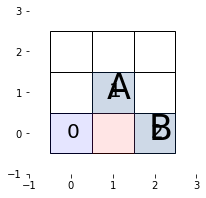

In [193]:
barrierPolicies = [policyA, policyB]

trap = trapStates if env =='barrier' else trapStatesGap

#Sample a goal
goalIndex = int(np.random.choice(2, 1)) # uniform random sample of goal
trueGoal = goalStates[goalIndex] #goalStateA goalStateB, goalStateC
print(trueGoal)
truePolicy = barrierPolicies[goalIndex] if env =='barrier' else gapPolicies[goalIndex]

#Sample a trajectory under that goal
sampleTrajectory = samplePathToGoal(startingPosition,truePolicy,transition, [trueGoal])

visualizeEnvironmentByState(states= stateSet, 
                            goalStates = goalStates, 
                            trapStates = trap, 
                            trajectory = sampleTrajectory,
                            goalNameDictionary=goalNames)


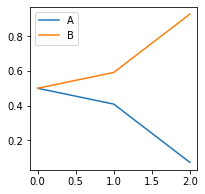

In [194]:
policySet = barrierPolicies if env =='barrier' else gapPolicies
prior =  [1/2., 1/2.]

inferGoal = PerformGoalInference(transition, policySet, prior, sampleTrajectory)
posteriorsToGoal = inferGoal()
plotPosteriors(posteriorsToGoal)